# Experiments on B3 samples

#### Imports Libraries


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,TensorDataset


import pandas as pd
import os
import glob
from pathlib import Path

import optuna # for trials hyperparameters
import mlflow # import for visually analysis of parameters
import mlflow.pytorch


import warnings
warnings.filterwarnings('ignore')


c:\Users\HP\anaconda3\envs\dl_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EXPERIMENT_NAME="LCMS_Optuna"
import os
os.environ["MLFLOW_TRACKING_URI"] = "file:///C:/mlflow_tracking"


# Local Experiment 

In [3]:
mlflow.set_experiment(EXPERIMENT_NAME)
exp = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
print(exp.artifact_location)


file:///C:/mlflow_tracking/645562133195251091


# Load GPU


In [4]:
# check for both NVIDIA or Mac Book

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print("Using:", DEVICE)


Using: cuda


In [5]:
RANDOM_STATE = 42

BATCH_SIZE = 64
EPOCHS = 100
LR = 1e-3


### Data Loading

In [6]:
df = pd.read_csv(r'C:\Project 2026\LSMS Project\LCMS\data\combined\inputs_none_all_batches_ZEROS.csv.zip', index_col='ID')
meta = df[['label','batch']]
X = df.drop(columns=['label','batch'])
y = df['label']

print("Samples:", len(df), "Features:", X.shape[1])
print("Number of classes: ", len(meta['label'].value_counts()))
print("Batches:", meta['batch'].value_counts().to_dict())
print("Labels:", meta['label'].value_counts().to_dict())




Samples: 1512 Features: 6725
Number of classes:  27
Batches: {'b3': 216, 'b4': 216, 'b5': 216, 'b6': 216, 'b7': 216, 'b8': 216, 'b9': 216}
Labels: {'blanc': 168, 'cal': 72, 'sma': 72, 'cko': 72, 'api': 72, 'cfam': 72, 'aba': 72, 'cgl': 72, 'sag': 72, 'cfr': 48, 'pmi': 48, 'mmo': 48, 'pst': 48, 'slu': 48, 'pre': 48, 'kae': 48, 'efc': 48, 'kox': 48, 'ecl': 48, 'cpa': 48, 'sha': 48, 'pvu': 48, 'aur': 48, 'pae': 24, 'efa': 24, 'eco': 24, 'sau': 24}


In [7]:
df.head(15)

,label,batch,359.0_0_1000,359.0_0_1020,359.0_0_1030,359.0_0_1050,359.0_0_1060,359.0_0_1080,359.0_0_1090,359.0_0_1110,...,872.0_320_900,872.0_320_910,872.0_320_920,872.0_320_930,872.0_320_940,872.0_320_950,872.0_320_960,872.0_320_970,872.0_320_980,872.0_320_990
ID,,,,,,,,,,,,,,,,,,,,,
sma_b3-02-29-2024_240216_u103_l,sma,b3,246.445786,114.216324,489.135040,110.375916,438.210785,254.849380,565.677795,41.565758,...,24.282871,11.091238,0.0,8.841338,8.747418,0.0,12.089150,20.171013,0.0,0.000000
pmi_b3-02-29-2024_230802_u111_l,pmi,b3,63.599636,71.337250,100.067116,128.706146,222.839294,219.990097,299.839966,64.458168,...,11.007890,98.616997,0.0,0.000000,76.318497,0.0,0.000000,0.000000,0.0,8.780501
efa_b3-02-29-2024_231108_u119_l,efa,b3,8.806048,89.737335,76.067886,136.388306,242.039276,198.487335,558.264099,62.103661,...,35.956249,94.177505,0.0,48.191074,34.931290,0.0,80.466232,70.913620,0.0,19.069780
cal_b3-02-29-2024_240221_u068_h,cal,b3,107.049583,78.271996,265.537567,53.900013,386.654602,379.996033,356.673615,74.927612,...,89.170670,114.145264,0.0,49.268127,172.875870,0.0,19.878231,46.694412,0.0,28.261786
sma_b3-02-29-2024_240216_u123_h,sma,b3,81.199501,222.661133,124.987297,123.657585,272.232452,326.412201,436.393158,129.655899,...,22.956703,57.551453,0.0,0.000000,36.712730,0.0,19.171818,63.670605,0.0,0.000000
efa_b3-02-29-2024_231108_u024_h,efa,b3,29.158253,289.553040,104.113541,52.867683,297.078308,579.588013,514.529297,100.561417,...,10.533655,28.594799,0.0,24.295166,10.660161,0.0,8.815858,44.934700,0.0,0.000000
slu_b3-02-29-2024_240216_u070_h,slu,b3,265.191711,57.590973,128.867188,78.215195,339.044250,167.216843,308.135284,48.087009,...,28.363766,20.644699,0.0,12.664742,95.551590,0.0,0.000000,16.251850,0.0,0.000000
cal_b3-02-29-2024_240221_u077_l,cal,b3,131.159790,81.644043,239.489990,49.848820,560.557922,328.665619,532.053650,31.243988,...,19.053064,39.311436,0.0,21.801914,20.017002,0.0,38.702507,9.352619,0.0,10.659986
slu_b3-02-29-2024_240216_u128_h,slu,b3,47.550262,252.733292,127.241341,97.416916,220.116699,407.621948,462.010284,157.322815,...,9.217565,26.910519,0.0,0.000000,43.879047,0.0,0.000000,39.191895,0.0,0.000000


### Prepocessing
Train - Test Split + Scaling  + Label Encoding

In [8]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y_enc,
    test_size=0.2,
    stratify=y_enc,
    random_state=RANDOM_STATE
)


In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Use Optuna

### MLP Classifer

In [10]:
# class MLP(nn.Module):
#     def __init__(self, input_dim, n_classes):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Linear(64, n_classes)
#         )

#     def forward(self, x):
#         return self.net(x)


In [11]:
class CustomOptunaMLP(nn.Module):
    def __init__(self,input_dim,output_dim,num_hidden_layers,neurons_per_layers,dropout_rate):
        super().__init__()
        layers=[]
        for layer in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim,neurons_per_layers))
            layers.append(nn.BatchNorm1d(neurons_per_layers))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim=neurons_per_layers
        layers.append(nn.Linear(neurons_per_layers,output_dim))


        self.model=nn.Sequential(
            *layers # Sequential need each layer indivially not in list so first unpack the list using (*) 
        )

        
    def forward(self,x):
        return self.model(x)

# Create DataSet


In [21]:
class LCMSDataset(Dataset):
    def __init__(self,features,labels):
        super().__init__()
        self.features=torch.tensor(features,dtype=torch.float32)
        self.labels=torch.tensor(labels,dtype=torch.long)

    def __getitem__(self, index):
        return self.features[index],self.labels[index]
    def __len__(self):
        return self.features.shape[0]
    
    


# Create Class Autoencoder

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z


In [16]:
def train_autoencoder(X_train, X_test, latent_dim):
    device_ae = torch.device("cpu")  # IMPORTANT
    model = Autoencoder(X_train.shape[1], latent_dim).to(device_ae)

    loader = DataLoader(
        torch.tensor(X_train, dtype=torch.float32),
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.MSELoss()

    best_val = np.inf
    best_state = None

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device_ae)

    for _ in range(EPOCHS):
        model.train()
        for xb in loader:
            xb = xb.to(device_ae)
            optimizer.zero_grad()
            recon, _ = model(xb)
            loss = criterion(recon, xb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            recon, _ = model(X_test_tensor)
            val_loss = criterion(recon, X_test_tensor).item()

        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    return model


## Precompute PCA & AE outside Optuna
Precompute latent spaces ONCE (NO GPU crash) when we run together 

In [ ]:
## Previous Notebook result 
'''        method  latent_dim  accuracy  f1_macro
0          PCA          10  0.224422  0.251899
1          PCA          50  0.382838  0.428360
2          PCA         100  0.468647  0.494917
3          PCA         500  0.544554  0.558510
4          PCA        1000  0.534653  0.549038
5  Autoencoder          10  0.270627  0.295281
6  Autoencoder          50  0.415842  0.432618
7  Autoencoder         100  0.488449  0.505846
8  Autoencoder         500  0.514851  0.532601
9  Autoencoder        1000  0.475248  0.487429'''

LATENT_DIMS = [500, 1000]

latent_cache = {}

for dim in LATENT_DIMS:

    # ---- PCA ----
    pca = PCA(n_components=dim, random_state=RANDOM_STATE)
    latent_cache[("PCA", dim)] = (
        pca.fit_transform(X_train),
        pca.transform(X_test)
    )

    # ---- Autoencoder (CPU ONLY) ----
    ae = train_autoencoder(
        X_train,
        X_test,
        dim
    )

    with torch.no_grad():
        Z_train = ae.encoder(
            torch.tensor(X_train, dtype=torch.float32)
        ).cpu().numpy()

        Z_test = ae.encoder(
            torch.tensor(X_test, dtype=torch.float32)
        ).cpu().numpy()

    latent_cache[("AE", dim)] = (Z_train, Z_test)


# Create Objective method for trials


## Create `train_classifier` for multiple Latent values

In [22]:
def train_classifier(X_train, y_train, X_test, y_test, input_dim, n_classes, params):

    model = CustomOptunaMLP(
        input_dim=input_dim,
        output_dim=n_classes,
        num_hidden_layers=params["num_hidden_layers"],
        neurons_per_layers=params["neurons_per_layers"],
        dropout_rate=params["dropout_rate"]
    ).to(DEVICE)

    train_loader = DataLoader(
        LCMSDataset(X_train, y_train),
        batch_size=params["batch_size"],
        shuffle=True
    )

    test_loader = DataLoader(
        LCMSDataset(X_test, y_test),
        batch_size=params["batch_size"]
    )

    criterion = nn.CrossEntropyLoss()

    if params["optimizer"] == "Adam":
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=params["learning_rate"],
            weight_decay=params["weight_decay"]
        )
    elif params["optimizer"] == "SGD":
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=params["learning_rate"],
            weight_decay=params["weight_decay"]
        )
    else:
        optimizer = torch.optim.RMSprop(
            model.parameters(),
            lr=params["learning_rate"],
            weight_decay=params["weight_decay"]
        )

    # ---- training ----
    for _ in range(params["epochs"]):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

    # ---- evaluation ----
    model.eval()
    preds, trues = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            preds.append(model(xb).argmax(1).cpu().numpy())
            trues.append(yb.numpy())

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    acc = accuracy_score(trues, preds)
    f1 = f1_score(trues, preds, average="macro")

    return acc, f1


## Create objective fun trail

In [23]:
def objective(trial):

    with mlflow.start_run(nested=True):

        # -------- latent space choices --------
        latent_dim = trial.suggest_categorical("latent_dim", [500, 1000])
        reduction_method = trial.suggest_categorical("reduction", ["PCA", "AE"])
        Xtr, Xte = latent_cache[(reduction_method, latent_dim)]
        # -------- classifier hyperparameters --------
        params = {
            "num_hidden_layers": trial.suggest_int("num_hidden_layers", 1, 5),
            "neurons_per_layers": trial.suggest_int("neurons_per_layers", 64, 256, step=64),
            "dropout_rate": trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1),
            "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128]),
            "epochs": trial.suggest_int("epochs", 20, 60, step=20),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
            "weight_decay": trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True),
            "optimizer": trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
        }

        mlflow.log_params(params)
        mlflow.log_param("latent_dim", latent_dim)
        mlflow.log_param("reduction", reduction_method)

        

        # -------- classifier --------
        acc, f1 = train_classifier(
            Xtr, y_train,
            Xte, y_test,
            input_dim=latent_dim,
            n_classes=len(np.unique(y_train)),
            params=params
        )

        mlflow.log_metric("val_accuracy", acc)
        mlflow.log_metric("val_f1", f1)

        return f1  # Optuna optimizes THIS


## Create study for trials

In [24]:


study=optuna.create_study(direction="maximize")#direction="maximize" bcz want to maximize accuracy if loss then will be "minimize"
study.optimize(objective, n_trials=30)

[I 2025-12-31 21:46:02,708] A new study created in memory with name: no-name-868548a7-3bd5-4fcb-8280-16bfc36b393a
[I 2025-12-31 21:46:09,165] Trial 0 finished with value: 0.5103195378120807 and parameters: {'latent_dim': 500, 'reduction': 'PCA', 'num_hidden_layers': 2, 'neurons_per_layers': 256, 'dropout_rate': 0.4, 'batch_size': 128, 'epochs': 40, 'learning_rate': 0.0062295680276631005, 'weight_decay': 0.0001288617624596811, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5103195378120807.
[I 2025-12-31 21:46:39,133] Trial 1 finished with value: 0.38755523690293664 and parameters: {'latent_dim': 1000, 'reduction': 'AE', 'num_hidden_layers': 4, 'neurons_per_layers': 128, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'epochs': 60, 'learning_rate': 0.00013384799913540308, 'weight_decay': 0.00017515280848180072, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.5103195378120807.
[I 2025-12-31 21:46:44,067] Trial 2 finished with value: 0.5102884585365481 and parameters: {'la

In [29]:
study.best_params

{'latent_dim': 500,
 'reduction': 'PCA',
 'num_hidden_layers': 1,
 'neurons_per_layers': 192,
 'dropout_rate': 0.5,
 'batch_size': 64,
 'epochs': 20,
 'learning_rate': 0.0006537207274072976,
 'weight_decay': 3.2963308213063554e-05,
 'optimizer': 'RMSprop'}

In [30]:
study.best_value

0.5518825557671404

In [32]:
study.best_trials

[FrozenTrial(number=11, state=<TrialState.COMPLETE: 1>, values=[0.5518825557671404], datetime_start=datetime.datetime(2025, 12, 31, 21, 47, 31, 755502), datetime_complete=datetime.datetime(2025, 12, 31, 21, 47, 34, 717496), params={'latent_dim': 500, 'reduction': 'PCA', 'num_hidden_layers': 1, 'neurons_per_layers': 192, 'dropout_rate': 0.5, 'batch_size': 64, 'epochs': 20, 'learning_rate': 0.0006537207274072976, 'weight_decay': 3.2963308213063554e-05, 'optimizer': 'RMSprop'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'latent_dim': CategoricalDistribution(choices=(500, 1000)), 'reduction': CategoricalDistribution(choices=('PCA', 'AE')), 'num_hidden_layers': IntDistribution(high=5, log=False, low=1, step=1), 'neurons_per_layers': IntDistribution(high=256, log=False, low=64, step=64), 'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.1, step=0.1), 'batch_size': CategoricalDistribution(choices=(32, 64, 128)), 'epochs': IntDistribution(high=60, log=Fal

# MLFlow Command
mlflow ui --backend-store-uri file:///C:/mlflow_tracking


run this command on your terminal 

  ## Accuracy with batches
62 , 128 batch_size is good 
try with different parameters 

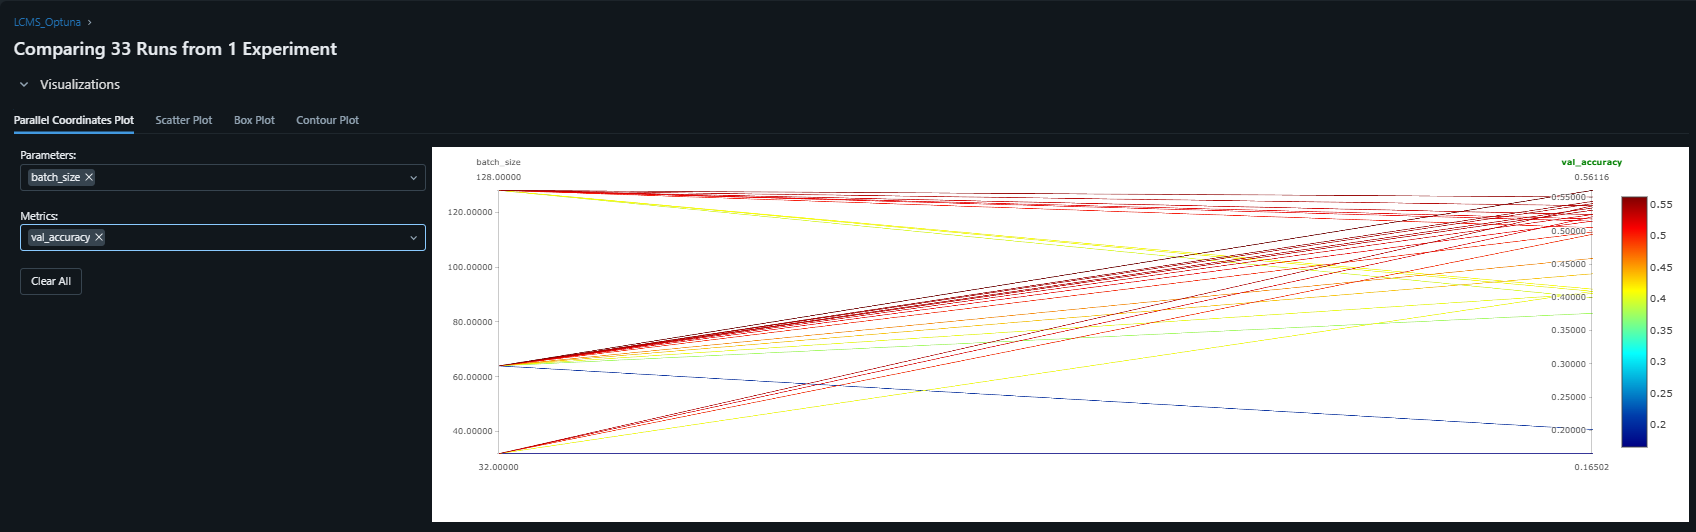

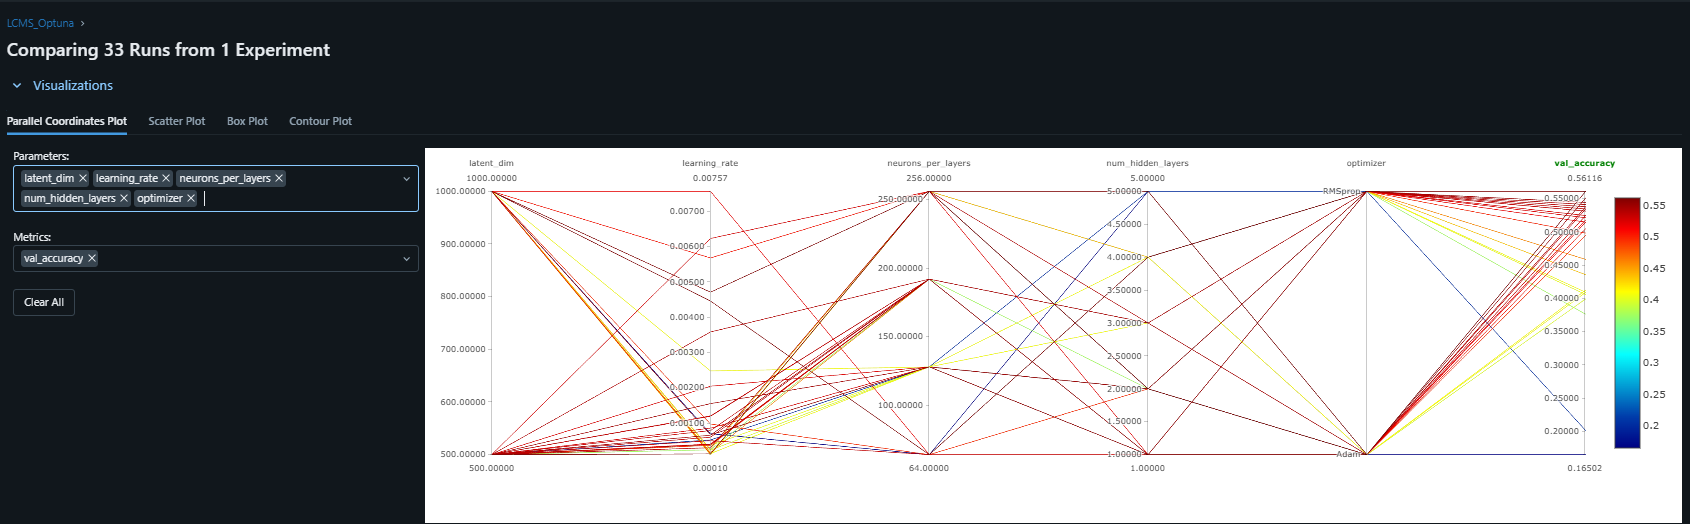